# Loading and Preprocessing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('DJA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date' , inplace=True)
df

,DJIA
Date,
1885-02-16,30.9226
1885-02-17,31.3365
1885-02-18,31.4744
1885-02-19,31.6765
1885-02-20,31.4252
...,...
2024-02-22,39069.1100
2024-02-23,39131.5300
2024-02-26,39069.2300


In [3]:
df.isna().sum()

DJIA    0
dtype: int64

as you see there is no null quantity in our dataset

In [4]:
df.describe()

,DJIA
count,37962.000000
mean,3360.308080
std,7017.812893
min,24.360400
25%,73.199650
50%,235.345000
75%,1781.637500
max,39131.530000


our data has a big difference between mean and max data and the standard deviation of data in comparison to mean is to high , so we use the logarithm of DJIA index

In [5]:
df['DJIA'] = np.log(df['DJIA'])

In [9]:
df2 = df.copy()

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
print(adfuller(df2['DJIA'])) 

(0.9340085413609213, 0.9935184779149431, 43, 37918, {'1%': -3.430522470666896, '5%': -2.861616227957431, '10%': -2.5668105737138274}, -236442.83362386288)


due to the Augmented Dickey Fuller Test, our data is non stationary so we use the difference of a DataFrame element compared with last element in the DataFrame. 

In [12]:
df2['DJIA'] = df2['DJIA'].diff()
df2 = df2.fillna(method='bfill')

In [13]:
print(adfuller(df2['DJIA'])) 

(-29.547104066686366, 0.0, 42, 37919, {'1%': -3.430522466118191, '5%': -2.861616225947069, '10%': -2.566810572643766}, -236443.95136051578)


After using the diff method and calculating the Augmented Dickey Fuller Test,now our data is stationary so I=1 is good for Integrated Component (I) of SARIMAX.


# holdout splitting

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error , r2_score

In [15]:
X_train, X_test = train_test_split(df, shuffle=False, test_size=.001 )
print(f'Train shape: {X_train.shape}  \nTest Shape: {X_test.shape}')

Train shape: (37924, 1)  
Test Shape: (38, 1)


# SARIMAX Model

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [21]:
model = SARIMAX(X_train['DJIA'], order=(3, 1, 3), seasonal_order=(3, 1, 3, 4))

C:\Users\DearUser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\DearUser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [22]:
res = model.fit()

C:\Users\DearUser\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              DJIA   No. Observations:                37924
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 4)   Log Likelihood              118067.267
Date:                           Sun, 03 Mar 2024   AIC                        -236108.534
Time:                                   21:44:45   BIC                        -235997.473
Sample:                                        0   HQIC                       -236073.292
                                         - 37924                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0165      1.791     -0.009      0.993      -3.528       3.495
ar.L2          0.0632      0.076      0.837      0.403      -0.085       0.211
ar.L3          0.0376      0.219      0.172      0.864      -0.392       0.467
ma.L1          0.0345      1.791      0.019      0.985      -3.476       3.545
ma.L2         -0.0683      0.093     -0.732      0.464      -0.251       0.115
ma.L3         -0.0055      0.228     -0.024      0.981      -0.452       0.441
ar.S.L4       -1.2755      0.063    -20.226      0.000      -1.399      -1.152
ar.S.L8       -0.8020      0.074    -10.770      0.000      -0.948      -0.656
ar.S.L12       0.0182      0.046      0.398      0.691      -0.071       0.108
ma.S.L4        0.3244      0.019     16.928      0.000       0.287       0.362
ma.S.L8       -0.4540      0.013    -35.064      0.000      -0.479      -0.429
ma.S.L12      -0.8538      0.018    -46.213      0.000      -0.890      -0.818
sigma2         0.0001   2.57e-07    448.006      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   2.41   Jarque-Bera (JB):            671217.16
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
df['sarimax'] = res.fittedvalues

In [42]:
forecast = res.predict(start=len(X_train), end=len(df) )

C:\Users\DearUser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [46]:
df['sarimax'].iloc[37923:] = forecast 

In [62]:
y_true_train = df['DJIA'][:37923]
y_true_test = df['DJIA'][37923:]
y_pred_train = df['sarimax'][:37923]
y_pred_test= df['sarimax'][37923:]

print( 'MAPE_train: ' ,mean_absolute_percentage_error(y_true_train,y_pred_train) )
print( 'R2_train: ' ,r2_score(y_true_train,y_pred_train) )
print( 'MAPE_test: ', mean_absolute_percentage_error(y_true_test,y_pred_test) )
print( 'R2_test: ' ,r2_score(y_true_test,y_pred_test) )

MAPE_train:  0.0013627985221407691
R2_train:  0.9998819800748594
MAPE_test:  0.0015447016100747864
R2_test:  -0.7725710500582428


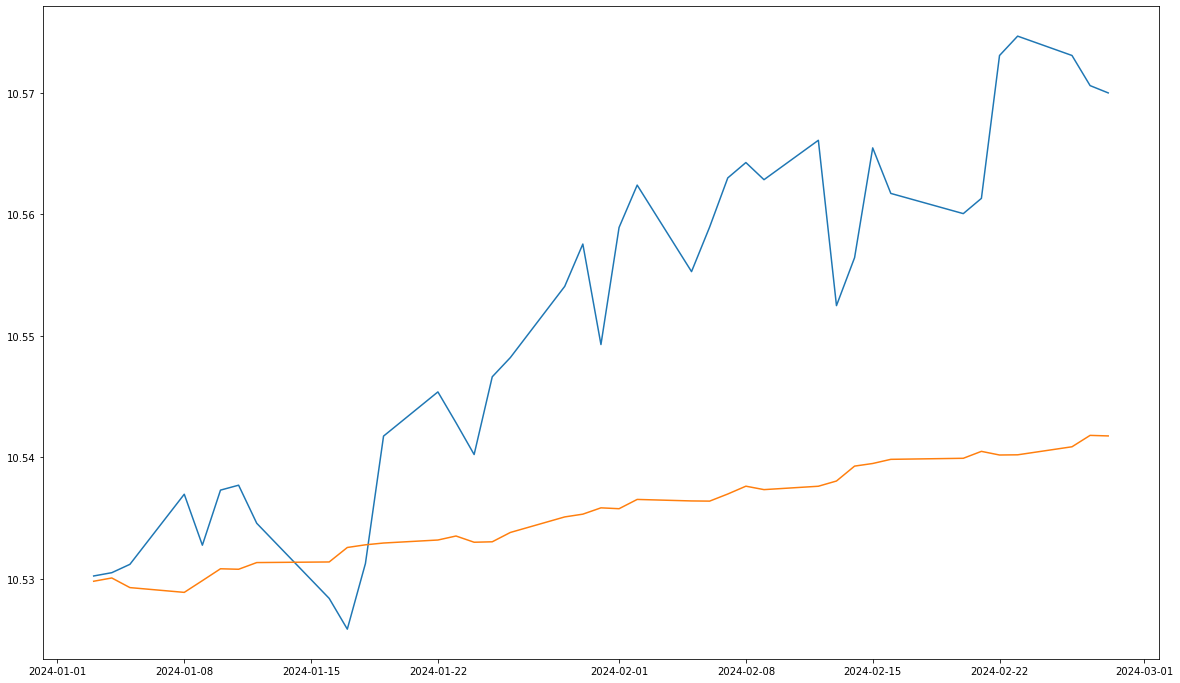

In [51]:
plt.figure(figsize=(20, 12))
plt.plot(df['DJIA'][37923:])
plt.plot(df['sarimax'][37923:])
plt.show()